<a href="https://colab.research.google.com/github/meichenfang/Poisson-regression/blob/main/demos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load packages

In [1]:
%cd ..

# Load before numpy to restrict its usage of cores, otherwise it will use all cores when doing @
import os
os.environ["BLAS_NUM_THREADS"] = "1" 
os.environ["OPENBLAS_NUM_THREADS"] = "1" # 

import Chronocell
print(Chronocell.__version__)

from Chronocell.inference import Trajectory
from Chronocell.mixtures import PoissonMixtureSS
from Chronocell.utils import *
from Chronocell.plotting import *

/home/mffang/workspace/Trajectory/FGP_2024
2024.10


In [2]:
import scipy.stats as stats
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA
import anndata as ad
import scanpy as sc
import scvelo as scv
import copy
from multiprocessing import Pool
import cmasher as cmr
import pickle
import tqdm
import time

Global seed set to 0


In [3]:
import rpy2
import rpy2.robjects as robjects

In [4]:
%load_ext rpy2.ipython

In [5]:
plt.rcParams['font.size'] = '24'
plt.rcParams['lines.linewidth'] = 6
plt.rcParams['lines.markersize'] = 12
plt.rcParams['figure.constrained_layout.use'] = True
label_font = '36'
legend_font = '24'

In [6]:
def norm(x):
    return (x-np.min(x))/(np.max(x)-np.min(x))

In [7]:
def getNeighbors(embed, n_neigh=100, p=1):
    """Get indices of nearest neighbors in embedding (shape n_samples,n_features)"""
    nbrs = NearestNeighbors(n_neighbors=n_neigh, p=p).fit(embed)
    distances, indices = nbrs.kneighbors(embed)
    return indices

def getJaccard(x1, x2, n_neigh=100, p=1):
    '''
    Get jaccard distance between embeddings
    
    Parameters
    ----------
    
    Returns
    -------
    '''
    assert len(x1.shape) == 2
    assert len(x2.shape) == 2
    embed1_neighbor = getNeighbors(x1,n_neigh,p=p)
    embed2_neighbor = getNeighbors(x2,n_neigh,p=p)
    frac = [0]*embed1_neighbor.shape[0]
    for i in range(embed1_neighbor.shape[0]):
        inter = set(embed1_neighbor[i,:]).intersection(embed2_neighbor[i,:])
        union = set(embed1_neighbor[i,:]).union(embed2_neighbor[i,:])
        frac[i] = 1-len(inter)/len(union)
    return frac


In [8]:
def empirical_entropy(X):
    n, p ,s = X.shape
    entropy = np.zeros(p)
    n_bins = np.zeros(p)
    for j in range(p):
        bins = [ np.arange(X[:,j,0].min(),X[:,j,0].max()+2)-0.5, np.arange(X[:,j,1].min(),X[:,j,1].max()+2)-0.5]
        p, edges = np.histogramdd(X[:,j],bins=bins,density=True)
        entropy[j] = - np.sum(p[p>0] * np.log(p[p>0]))
        n_bins[j] = np.sum(p>0)
    return entropy, n_bins

# dyngen
We follow the [Getting started](https://dyngen.dynverse.org/articles/getting_started.html)

In [9]:
%%R 

library(tidyverse)
library(dyngen)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [10]:
%%R 
# the simulation is being sped up because rendering all vignettes with one core
# for pkgdown can otherwise take a very long time
set.seed(1)

backbone <- backbone_bifurcating()

num_cells <- 10000
num_features <- 200

# genes are divided up such that there are nrow(module_info) TFs and
# the rest is split between targets and HKs evenly.
num_tfs <- nrow(backbone$module_info)
num_targets <- (num_features - num_tfs)
num_hks <- 0 #num_features - num_targets - num_tfs

num_targets

[1] 165


In [11]:
%%R 

config <-
  initialise_model(
    backbone = backbone,
    num_cells = num_cells,
    num_tfs = num_tfs,
    num_targets = num_targets,
    num_hks = num_hks,
    verbose = FALSE,
    download_cache_dir = tools::R_user_dir("dyngen", "data"),
    simulation_params = simulation_default(
      total_time = 1000,
      census_interval = 10, 
      ssa_algorithm = ssa_etl(tau = 300/3600),
      experiment_params = simulation_type_wild_type(num_simulations = 200)
    ),
    experiment = experiment_snapshot()
  )

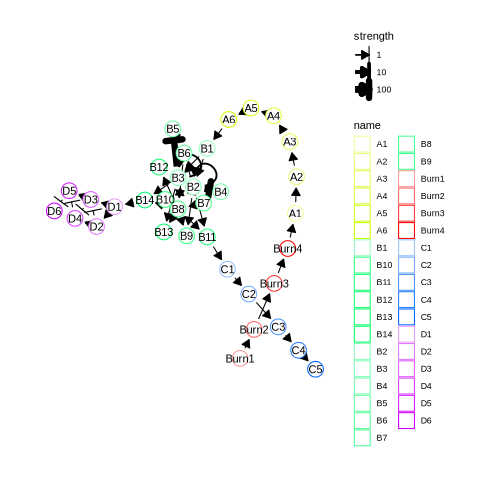

In [12]:
%%R
plot_backbone_statenet(config)
plot_backbone_modulenet(config)

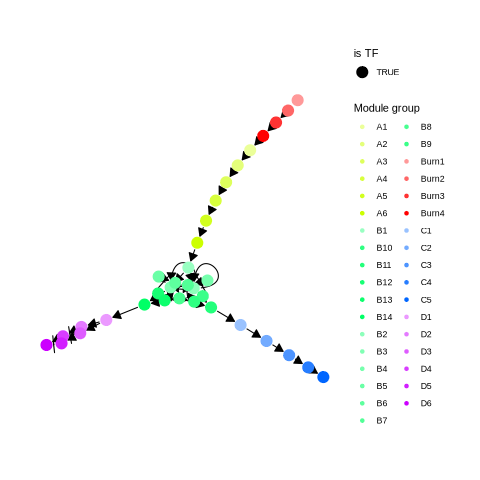

In [13]:
%%R

model <- generate_tf_network(config)
plot_feature_network(model, show_targets = FALSE)

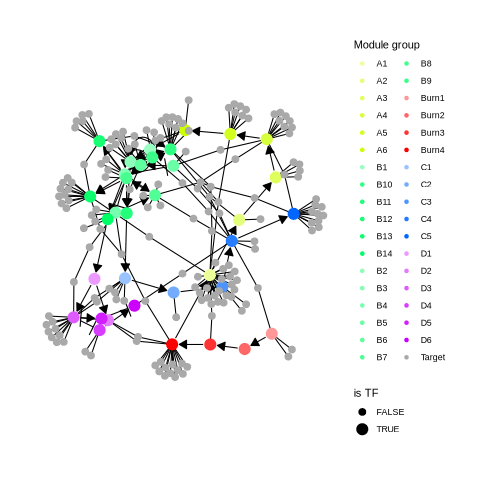

In [14]:
%%R
model <- generate_feature_network(model)
plot_feature_network(model)

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~01s           |+                                                 | 2 % ~01s           |++                                                | 3 % ~01s           |++                                                | 4 % ~01s           |+++                                               | 5 % ~01s           |+++                                               | 6 % ~01s           |++++                                              | 7 % ~01s           |++++                                              | 8 % ~01s           |+++++                                             | 9 % ~01s           |+++++                                             | 10% ~01s           |++++++                                            | 11% ~01s           |++++++                                            | 12% ~01s           |+++++++                                           | 13% ~01s 

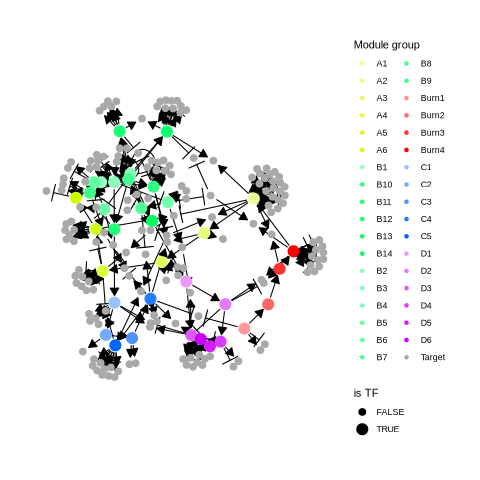

In [15]:
%%R
model <- generate_kinetics(model)
plot_feature_network(model)

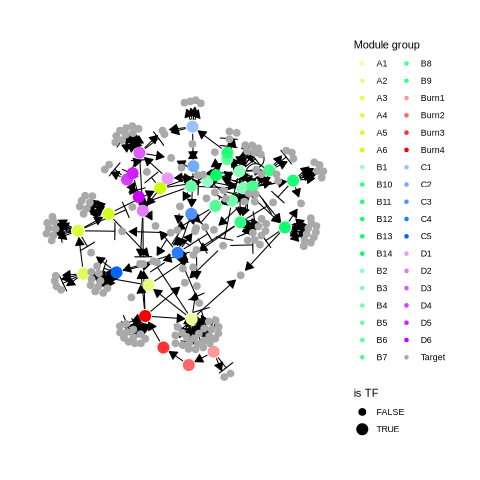

In [16]:
%%R

plot <- plot_feature_network(model)

# Save the plot as a high-resolution PDF in the 'figures' directory
ggsave("figures/dyngen_network.pdf", plot = plot, device = "pdf", width = 6, height = 6, dpi = 300)

# Optionally, display the plot in the R environment
print(plot)

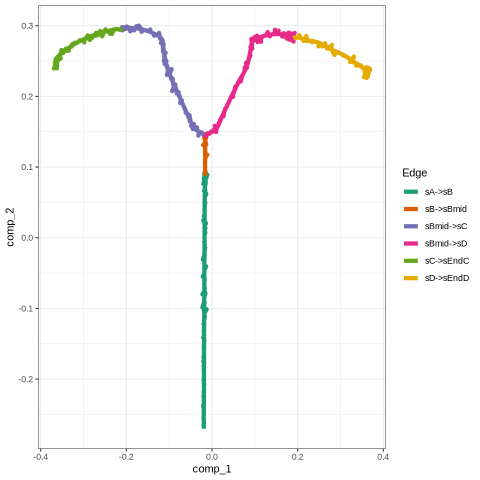

In [17]:
%%R

# Assuming model is already defined and contains the necessary data
model <- generate_gold_standard(model)

# Generate the plot
plot <- plot_gold_simulations(model) + scale_colour_brewer(palette = "Dark2")

# Save the plot as a high-resolution PDF in the 'figures' directory
ggsave("figures/dyngen.pdf", plot = plot, device = "pdf", width = 8, height = 6, dpi = 300)

# Optionally, display the plot in the R environment
print(plot)

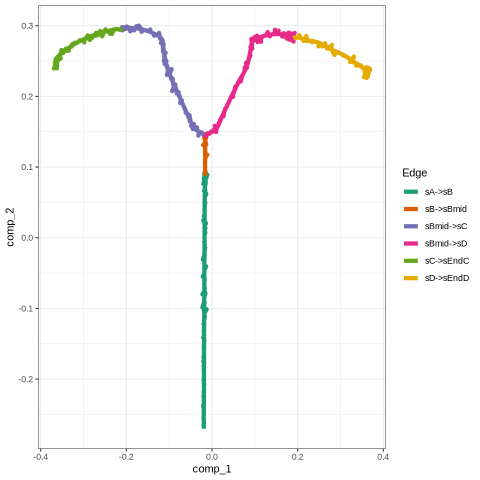

In [18]:
%%R

# Generate the plot
plot <- plot_gold_simulations(model) + scale_colour_brewer(palette = "Dark2")

# Save the plot as a high-resolution PDF in the 'figures' directory
ggsave("figures/dyngen.pdf", plot = plot, device = "pdf", width = 5, height = 3, dpi = 300)

# Optionally, display the plot in the R environment
print(plot)

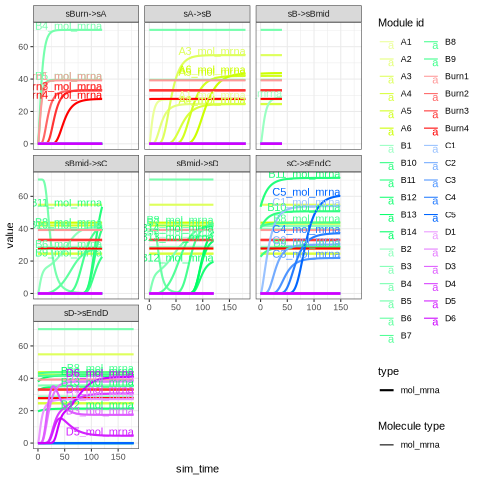

In [19]:
%%R

plot_gold_expression(model, what = "mol_mrna") # mrna

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~05m 16s       |+                                                 | 2 % ~05m 15s       |++                                                | 3 % ~05m 07s       |++                                                | 4 % ~05m 04s       |+++                                               | 5 % ~05m 00s       |+++                                               | 6 % ~04m 55s       |++++                                              | 7 % ~04m 52s       |++++                                              | 8 % ~04m 49s       |+++++                                             | 9 % ~04m 45s       |+++++                                             | 10% ~04m 41s       |++++++                                            | 11% ~04m 37s       |++++++                                            | 12% ~04m 34s       |+++++++                                           | 13% ~04m 

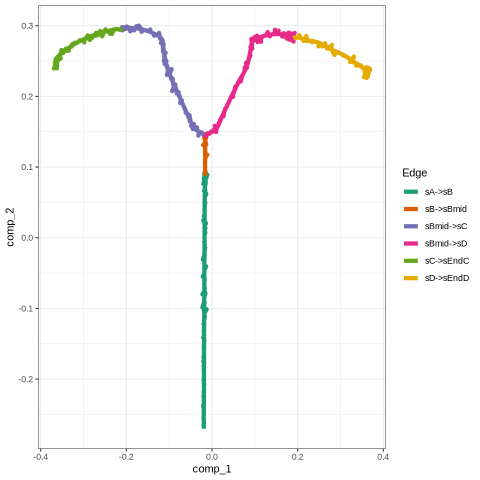

In [20]:
%%R
model <- generate_cells(model)
plot_simulations(model)
# Save the plot as a high-resolution PDF in the 'figures' directory
ggsave("figures/dyngen_simulations.pdf", plot = plot, device = "pdf", width = 8, height = 6, dpi = 300)

# Optionally, display the plot in the R environment
print(plot)

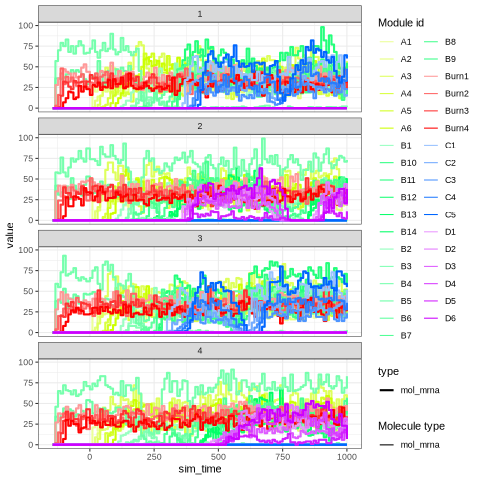

In [21]:
%%R

plot_simulation_expression(model, 1:4, what = "mol_mrna")

In [22]:
%%R

model <- generate_experiment(model)

In [23]:
%%R

library(anndata)
ad <- as_anndata(model)
ad$write_h5ad("data/dyngen_bif_1_10000.h5ad")


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

R[write to console]: 
Attaching package: ‘anndata’


R[write to console]: The following object is masked from ‘package:readr’:

    read_csv




None


# Load data

In [9]:
adata = ad.read('data/dyngen_bif_1_10000.h5ad')
adata

AnnData object with n_obs × n_vars = 10000 × 200
    obs: 'step_ix', 'simulation_i', 'sim_time'
    var: 'module_id', 'basal', 'burn', 'independence', 'color', 'is_tf', 'is_hk', 'transcription_rate', 'splicing_rate', 'translation_rate', 'mrna_halflife', 'protein_halflife', 'mrna_decay_rate', 'protein_decay_rate', 'max_premrna', 'max_mrna', 'max_protein', 'mol_premrna', 'mol_mrna', 'mol_protein'
    uns: 'traj_dimred_segments', 'traj_milestone_network', 'traj_progressions'
    obsm: 'dimred'
    layers: 'counts_protein', 'counts_spliced', 'counts_unspliced', 'logcounts'

In [10]:
n, p = adata.X.shape
X=np.zeros((n,p,2))
X[:,:,0]=adata.layers["counts_unspliced"].toarray()
X[:,:,1]=adata.layers["counts_spliced"].toarray()
print(X[:,:,0].mean(),X[:,:,1].mean())

true_t = adata.obs["sim_time"]/adata.obs["sim_time"].max()
counts = adata.layers["counts_spliced"].toarray().T

0.618294 1.1709295


# Chronocell

In [ ]:
topo = np.array([[0,1,2,3,4],[0,1,2,5,6]],dtype=int)
tau = np.array((0,1,2,3,4),dtype=float)
tau = tau/tau[-1]

Input_args = []
def fit_wrapper(seed):
    traj = Trajectory(topo, tau, model="two_species_ss", verbose=0)
    traj = traj.fit(X,m=100,n_init=1,perm_theta=False,epoch=100,parallel=False,n_threads=1,seed=seed)
    return traj
    
for seed in range(50):
    Input_args.append([seed])
            
with Pool(50) as pool:      
    trajs = pool.starmap(fit_wrapper, Input_args, chunksize=1)

with open('results/dyngen/bif_1_10000_6.pickle', 'wb') as f:
    pickle.dump(trajs, f, pickle.HIGHEST_PROTOCOL)

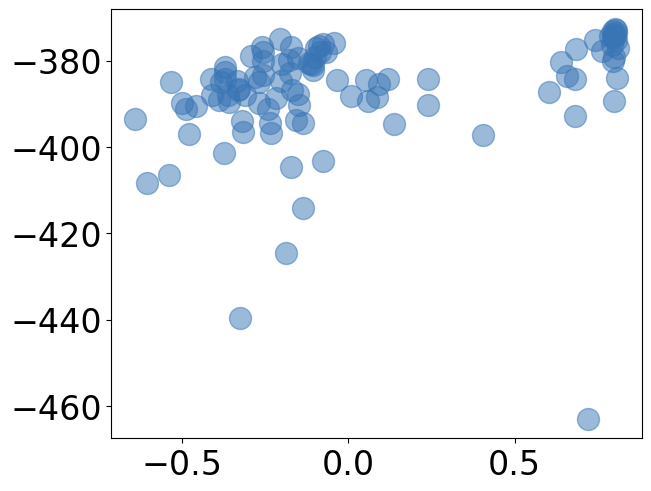

In [30]:
corrs = []
elbos = []
for traj_ in trajs:
    t_hat = traj_.Q.sum(1) @ traj_.t
    corrs.append(stats.pearsonr(true_t,t_hat)[0])
    elbos.append(traj_.elbos[-1])

traj = trajs[np.argmax(elbos)]
fig, ax = plt.subplots(1,1)
plt.scatter(corrs,elbos,s=1000,marker='.',color='#3975b5',alpha=0.5)

<AxesSubplot:>

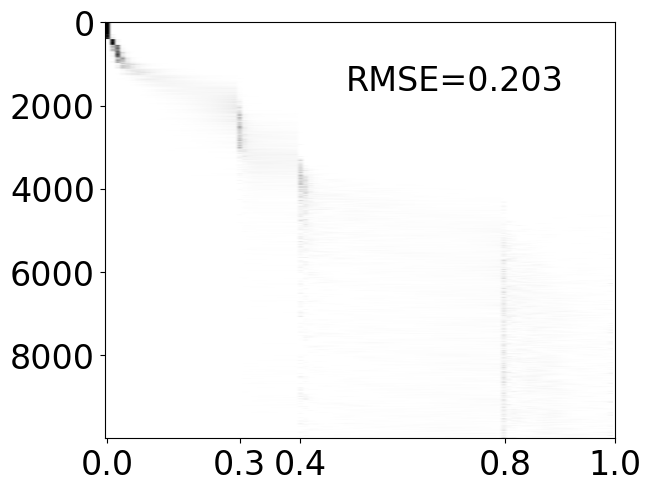

In [31]:
plot_t(traj,t=norm(true_t),order_cells=True)

In [ ]:
traj_tau = Trajectory(topo=traj.topo, tau=traj.tau, model="two_species_ss_tau",verbose=2)
traj_tau = traj_tau.fit(X,warm_start=True,Q=traj.Q,fit_tau=False,norm_Q=True,epoch=100,parallel=True,n_threads=10)   

In [11]:
with open('results/dyngen/bif_1_10000.pickle', 'rb') as f:
    results = pickle.load(f)
    
trajs = results['syn']
traj_tau = results['desyn']

<AxesSubplot:>

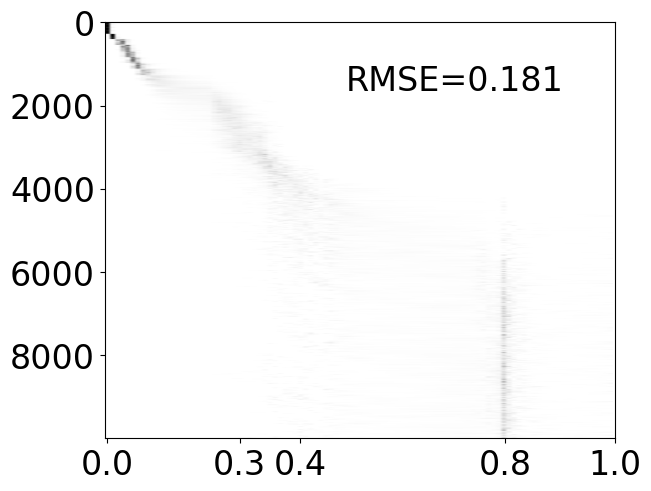

In [12]:
plot_t(traj_tau,t=true_t,order_cells=True)

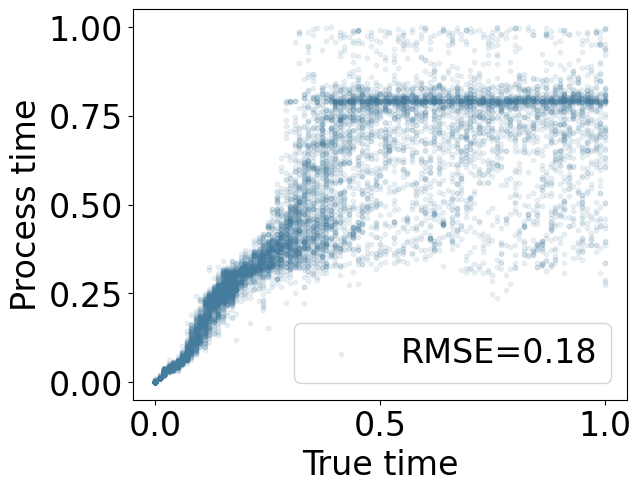

In [63]:
t = traj_tau.Q.sum(1) @ traj_tau.t
rmse = np.sqrt(np.mean((true_t-t)**2))

plt.scatter(norm(true_t),norm(t),s=10,color='#457b9d',alpha=0.1,label='RMSE='+str(np.around(rmse,2)))
plt.xlabel('True time')
plt.ylabel('Process time')
plt.legend()

In [39]:
adata.var

,module_id,basal,burn,independence,color,is_tf,is_hk,transcription_rate,splicing_rate,translation_rate,mrna_halflife,protein_halflife,mrna_decay_rate,protein_decay_rate,max_premrna,max_mrna,max_protein,mol_premrna,mol_mrna,mol_protein
Burn1_TF1,Burn1,1.0000,True,1.0,#FF9999,True,False,14.251983,0.346574,119.356101,3.126201,6.808238,0.221722,0.101810,25.078474,39.200176,45955.964320,mol_premrna_Burn1_TF1,mol_mrna_Burn1_TF1,mol_protein_Burn1_TF1
Burn2_TF1,Burn2,0.0000,True,1.0,#FF6666,True,False,13.420533,0.346574,136.449221,3.375160,5.710669,0.205367,0.121378,24.315169,41.033796,46129.024942,mol_premrna_Burn2_TF1,mol_mrna_Burn2_TF1,mol_protein_Burn2_TF1
Burn3_TF1,Burn3,0.0000,True,1.0,#FF3333,True,False,19.725200,0.346574,106.220371,2.784911,9.002904,0.248894,0.076992,33.125576,46.125897,63637.015796,mol_premrna_Burn3_TF1,mol_mrna_Burn3_TF1,mol_protein_Burn3_TF1
Burn4_TF1,Burn4,0.0000,True,1.0,#FF0000,True,False,16.418148,0.346574,136.692432,2.927175,7.573342,0.236797,0.091525,28.143584,41.190596,61518.350498,mol_premrna_Burn4_TF1,mol_mrna_Burn4_TF1,mol_protein_Burn4_TF1
A1_TF1,A1,0.0000,False,1.0,#EBFF99,True,False,13.893635,0.346574,138.513978,3.387112,8.289648,0.204643,0.083616,25.205424,42.686802,70712.766567,mol_premrna_A1_TF1,mol_mrna_A1_TF1,mol_protein_A1_TF1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Target161,NaN,0.0001,True,1.0,NaN,False,False,14.935746,0.346574,118.407717,4.212228,7.597850,0.164556,0.091229,29.221059,61.542879,79877.248267,mol_premrna_Target161,mol_mrna_Target161,mol_protein_Target161
Target162,NaN,1.0000,True,1.0,NaN,False,False,11.846382,0.346574,133.692805,4.444786,5.050158,0.155946,0.137253,23.573964,52.390607,51031.808751,mol_premrna_Target162,mol_mrna_Target162,mol_protein_Target162
Target163,NaN,0.0001,True,1.0,NaN,False,False,17.535377,0.346574,144.519013,2.766129,8.846058,0.250584,0.078357,29.364747,40.613335,74906.237083,mol_premrna_Target163,mol_mrna_Target163,mol_protein_Target163
Target164,NaN,0.0001,True,1.0,NaN,False,False,14.090797,0.346574,138.986265,4.307206,7.891593,0.160927,0.087834,27.765067,59.794928,94618.362793,mol_premrna_Target164,mol_mrna_Target164,mol_protein_Target164


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


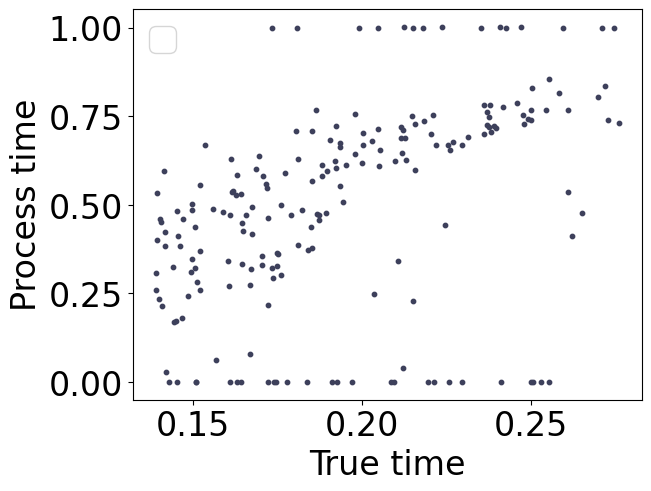

In [49]:
x = adata.var['mrna_decay_rate']#/0.346574	
y = traj_tau.theta[:,-1]/traj_tau.theta[:,-2]

plt.scatter(x,y,s=10,color='#3d405b')
plt.xlabel('True time')
plt.ylabel('Process time')
plt.legend()

In [ ]:
data = {'syn':trajs,'desyn':traj_tau}

with open('results/dyngen/bif_1_10000.pickle', 'wb') as f:
    pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)

# Slingshot + tradeSeq
We follow the step in https://bioconductor.org/packages/devel/bioc/vignettes/slingshot/inst/doc/vignette.html

In [45]:
%%R 

library(tradeSeq, quietly = TRUE)
library(RColorBrewer, quietly = TRUE)
library(SingleCellExperiment, quietly = TRUE)
library(slingshot, quietly = TRUE)
library(umap, quietly = TRUE)
library(scran, quietly = TRUE)
library(scater, quietly = TRUE)
library(scuttle, quietly = TRUE)
library(Seurat, quietly = TRUE)
library(mclust, quietly = TRUE)

R[write to console]: 
Attaching package: ‘MatrixGenerics’


R[write to console]: The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOrderStats, rowProds, rowQuantiles, rowRanges, rowRanks,
    rowSdDiffs, rowSds, rowSums2, rowTabulates, rowVarDiffs, rowVars,
    r


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

R[write to console]: 
Attaching package: ‘scran’


R[write to console]: The following object is masked from ‘package:TrajectoryUtils’:

    createClusterMST


R[write to console]: Attaching SeuratObject

R[write to console]: ‘SeuratObject’ was built under R 4.3.1 but the current version is
4.3.3; it is recomended that you reinstall ‘SeuratObject’ as the ABI
for R may have changed

R[write to console]: Seurat v4 was just loaded with SeuratObject v5; disabling v5 assays and
validation routines, and ensuring assays work in strict v3/v4
compatibility mode

R[write to console]: 
Attaching package: ‘Seurat’


R[write to console]: The following object is masked from ‘package:SummarizedExperiment’:

    Assays


R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.0
Type 'citation("mclust")' for citing this R package in publications.



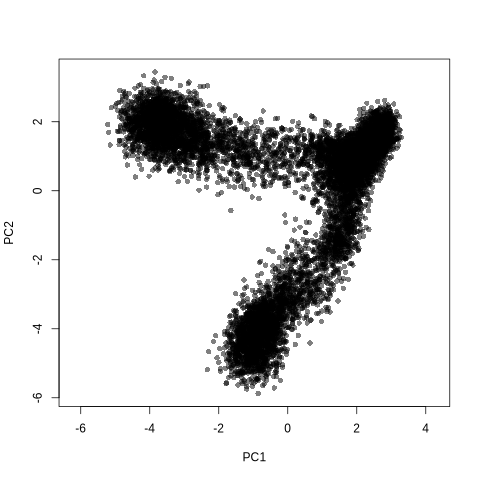

In [46]:
%%R -i counts

set.seed(42)
sce <- SingleCellExperiment(assays = list(counts = counts))
geneFilter <- apply(assays(sce)$counts,1,function(x){
    sum(x >= 3) >= 10
})
sce <- sce[geneFilter, ]

FQnorm <- function(counts){
    rk <- apply(counts,2,rank,ties.method='min')
    counts.sort <- apply(counts,2,sort)
    refdist <- apply(counts.sort,1,median)
    norm <- apply(rk,2,function(r){ refdist[r] })
    rownames(norm) <- rownames(counts)
    return(norm)
}
assays(sce)$norm <- FQnorm(assays(sce)$counts)

pca <- prcomp(t(log1p(assays(sce)$norm)), scale. = FALSE)
rd1 <- pca$x[,1:2]
reducedDims(sce) <- SimpleList(PCA = rd1)
plot(rd1, col = rgb(0,0,0,.5), pch=16, asp = 1)

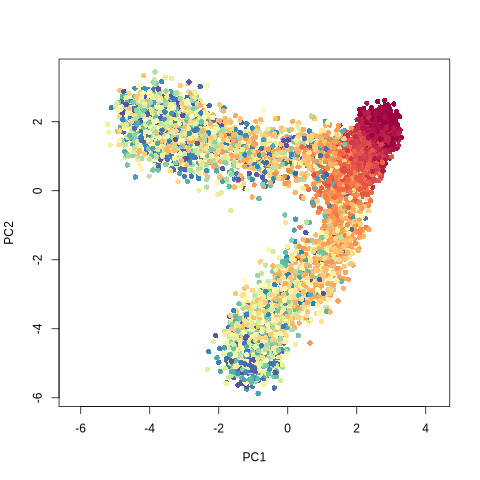

In [47]:
%%R -i true_t
# Create a continuous color ramp from the Spectral colormap
color_ramp <- colorRampPalette(brewer.pal(11, "Spectral"))

# Normalize true_t (or C) to [0, 1]
norm_true_t <- (true_t - min(true_t)) / (max(true_t) - min(true_t))

# Create a palette of 100 colors from the Spectral colormap
colors <- color_ramp(100)

# Map normalized true_t to the color palette using cut()
mapped_colors <- colors[cut(norm_true_t, breaks = 100)]

# Plot the reduced dimensions (rd) with colors based on continuous true_t
plot(rd1, col = mapped_colors, pch = 16, asp = 1)

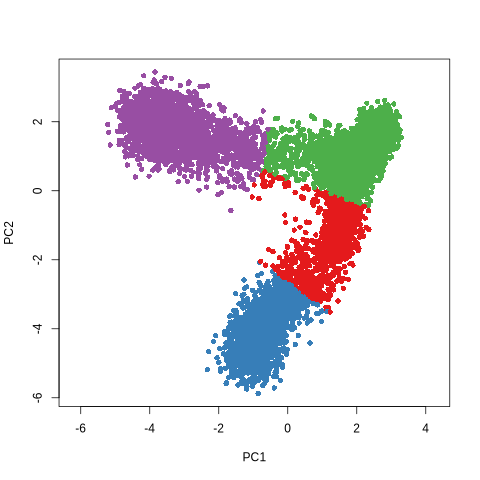

In [48]:
%%R
cl2 <- kmeans(rd1, centers = 4)$cluster
colData(sce)$kmeans <- cl2

plot(rd1, col = brewer.pal(9,"Set1")[cl2], pch=16, asp = 1)

## Set1: red blue green purple

In [50]:
%%R
# slingshot with the true start cluster provided
sce <- slingshot(sce, clusterLabels = 'kmeans', reducedDim = 'PCA', start.clus = 3)
colData(sce)$slingshot

class: PseudotimeOrdering 
dim: 10000 2 
metadata(4): lineages mst slingParams curves
pathStats(2): pseudotime weights
cellnames(10000): Cell-1 Cell-2 ... Cell-9999 Cell-10000
cellData names(2): reducedDim clusterLabels
pathnames(2): Lineage1 Lineage2
pathData names(0):


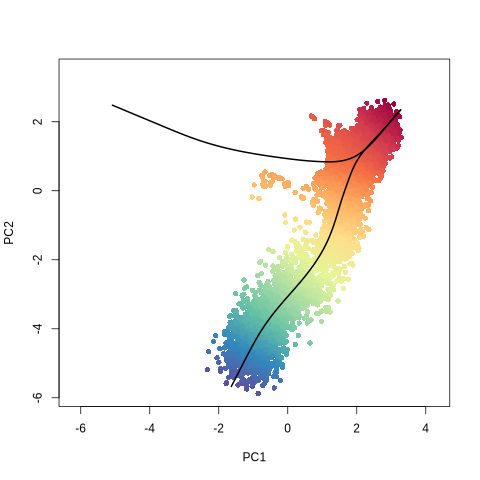

In [51]:
%%R
library(grDevices)
colors <- colorRampPalette(brewer.pal(11,'Spectral')[-6])(100)
plotcol <- colors[cut(sce$slingPseudotime_1, breaks=100)]

plot(reducedDims(sce)$PCA, col = plotcol, pch=16, asp = 1)
lines(SlingshotDataSet(sce), lwd=2, col='black')

In [52]:
%%R

#pdf('principle_curve.pdf')
par(mar = c(4, 6, 0, 0))

weights = slingCurveWeights(sce)
weight = weights/rowSums(weights)
time1 = sce$slingPseudotime_1
time1[is.na(time1)] = 0
time2 = sce$slingPseudotime_2
time2[is.na(time2)] = 0
x_pca = reducedDims(sce)$PCA

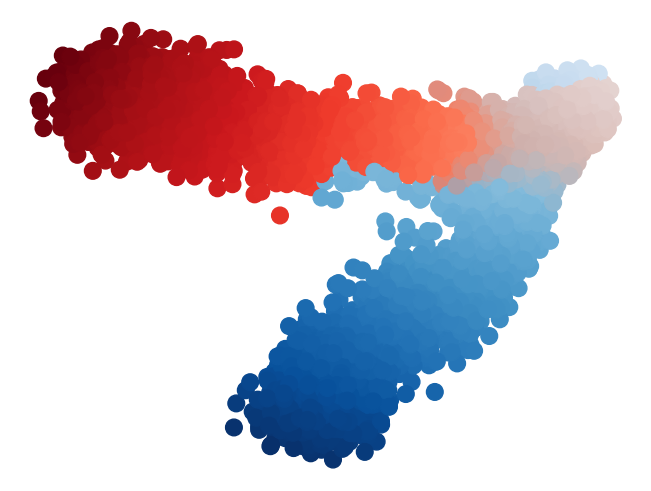

In [53]:
time1 = robjects.r['time1']
time2 = robjects.r['time2']
weight = np.array(robjects.r['weight'])
x_pca = np.array(robjects.r['x_pca'])
cmap_1 = cmr.get_sub_cmap('Blues', 0.2, 1)
cmap_2 = cmr.get_sub_cmap('Reds', 0.2, 1)

color_1 = weight[:,0,None]*np.array(cmap_1(time1/np.max(time1)))[:,:3]
color_2 = weight[:,1,None]*np.array(cmap_2(time2/np.max(time2)))[:,:3]
t_color = color_1 + color_2

plotcol = []
for (r,g,b) in t_color:
    plotcol.append('#%02x%02x%02x' % (int(r*255), int(g*255), int(b*255)))
    
fig, ax = plt.subplots(1,1)
im=ax.scatter(x_pca[:,0],x_pca[:,1],c=plotcol);
#ax.set_xlabel('PC1',fontsize=24)
#ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);
#plt.colorbar(im,fraction=0.05, shrink=0.9) # adding the colobar on the right

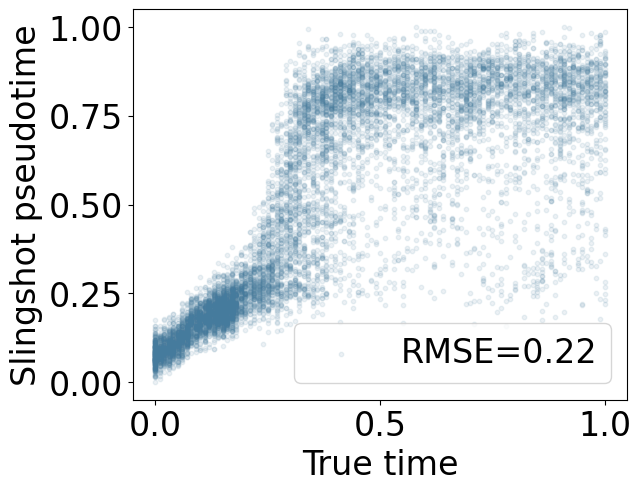

In [70]:
t = weight[:,0]*np.array(time1/np.max(time1)) + weight[:,1]*np.array(time2/np.max(time2))
rmse = np.sqrt(np.mean((norm(true_t)-norm(t))**2))

plt.scatter(true_t,t,s=10,color='#457b9d',alpha=0.1,label='RMSE='+str(np.around(rmse,2)))
plt.xlabel('True time')
plt.ylabel('Slingshot pseudotime')
plt.legend()

# DPT

We follow this [tutorial](https://scanpy.readthedocs.io/en/stable/tutorials/trajectories/paga-paul15.html)

In [9]:
data = sc.read('data/dyngen_bif_1_10000.h5ad')
data

AnnData object with n_obs × n_vars = 10000 × 200
    obs: 'step_ix', 'simulation_i', 'sim_time'
    var: 'module_id', 'basal', 'burn', 'independence', 'color', 'is_tf', 'is_hk', 'transcription_rate', 'splicing_rate', 'translation_rate', 'mrna_halflife', 'protein_halflife', 'mrna_decay_rate', 'protein_decay_rate', 'max_premrna', 'max_mrna', 'max_protein', 'mol_premrna', 'mol_mrna', 'mol_protein'
    uns: 'traj_dimred_segments', 'traj_milestone_network', 'traj_progressions'
    obsm: 'dimred'
    layers: 'counts_protein', 'counts_spliced', 'counts_unspliced', 'logcounts'

In [69]:
sc.pp.recipe_zheng17(data, n_top_genes=127)
sc.tl.pca(data, svd_solver="arpack")

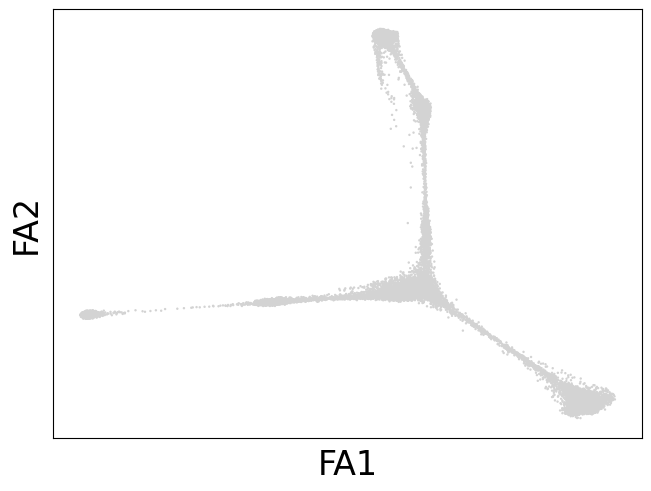

In [70]:
sc.pp.neighbors(data)
sc.tl.draw_graph(data)

sc.tl.diffmap(data)
sc.pp.neighbors(data, n_neighbors=10, use_rep="X_diffmap")
sc.pl.draw_graph(data, legend_loc="on data")

In [71]:
sc.tl.leiden(data)
sc.tl.paga(data, groups="leiden")

In [10]:
np.where(data.obs['sim_time']==0)

(array([   0,    6,   61,   65,   82,   99,  156,  184,  216,  240,  267,
         347,  392,  395,  407,  459,  503,  525,  563,  573,  603,  631,
         654,  716,  734,  766,  780,  847,  869,  871,  882,  890,  903,
         917,  926,  944,  958,  962,  971,  989, 1030, 1078, 1149, 1176,
        1186, 1207, 1214, 1232, 1241, 1273, 1290, 1322, 1335, 1374, 1427,
        1439, 1453, 1467, 1505, 1509, 1539, 1547, 1550, 1557, 1650, 1667,
        1695, 1718, 1723, 1751, 1763, 1771, 1788, 1795, 1897, 1929, 1954,
        1976, 1996, 2033, 2036, 2065, 2111, 2152, 2227, 2230, 2273, 2293,
        2345, 2406, 2429, 2475, 2486, 2505, 2552, 2581, 2630, 2674, 2694,
        2719, 2743, 2754, 2787, 2795, 2907, 3037, 3052, 3129, 3159, 3187,
        3189, 3191, 3194, 3229, 3245, 3298, 3371, 3382, 3395, 3398, 3519,
        3528, 3562, 3630, 3667, 3723, 3745, 3767, 3839, 3897, 3920, 3922,
        3923, 3961, 4031, 4045, 4048, 4062, 4171, 4181, 4203, 4333, 4343,
        4378, 4398, 4435, 4436, 4507, 

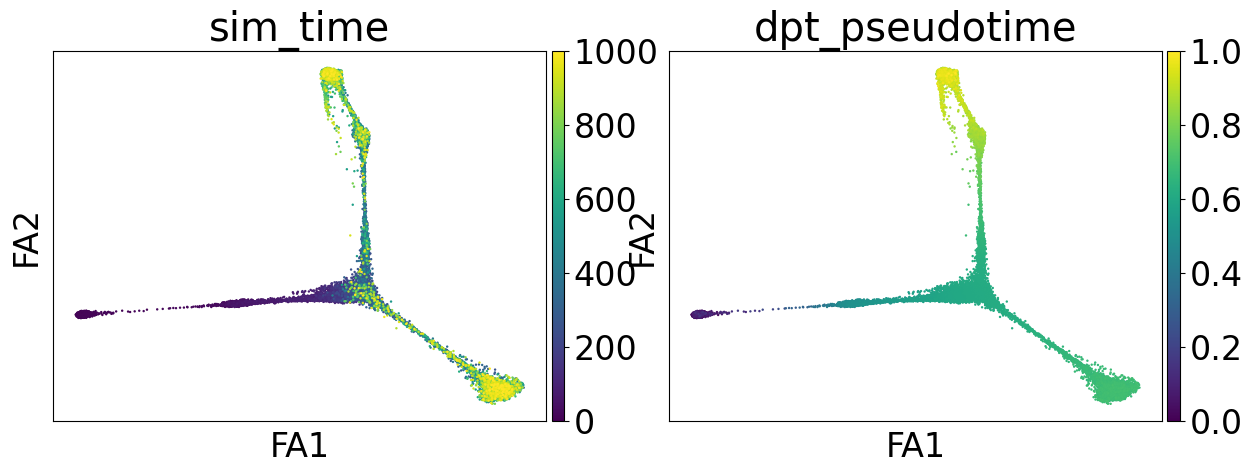

In [77]:
data.uns["iroot"] = 0
sc.tl.dpt(data)
sc.pl.draw_graph(data, color=["sim_time", "dpt_pseudotime"], legend_loc="on data")

In [65]:
data = sc.read('results/dyngen/bif_1_10000_dpt.h5ad')

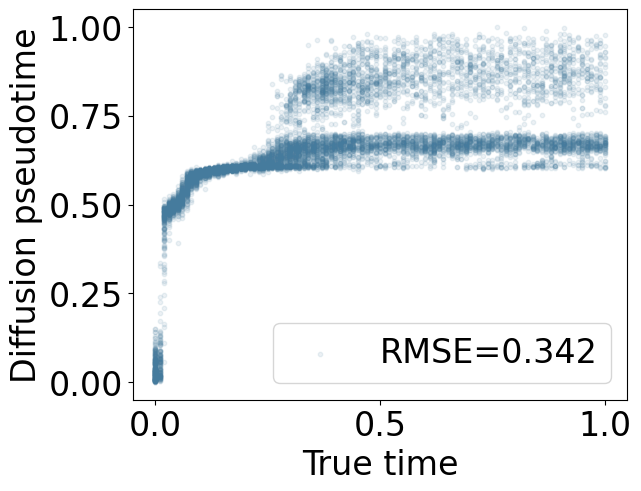

In [71]:
# Extract pseudotime
t = data.obs["dpt_pseudotime"]
true_t = data.obs["sim_time"]

# Normalize
true_t = norm(true_t)
t = norm(t)

# Remove NaN values
mask = ~np.isnan(t) & ~np.isinf(t)  # Mask to ignore NaNs in both true_t and t
filtered_t = t[mask]
filtered_true_t = true_t[mask]

# Calculate RMSE
rmse = np.sqrt(np.mean((filtered_true_t - filtered_t) ** 2))

# Plot the results
plt.scatter(filtered_true_t, filtered_t, s=10, color='#457b9d', alpha=0.1, label='RMSE=' + str(np.around(rmse, 3)))
plt.xlabel('True time')
plt.ylabel('Diffusion pseudotime')
plt.legend()
plt.show()

In [79]:
data.write('results/dyngen/bif_1_10000_dpt.h5ad')

# VeloVI

https://velovi.readthedocs.io/en/latest/tutorial.html

In [46]:
import scanpy as sc
import scvelo as scv
import torch
from velovi import preprocess_data, VELOVI

import seaborn as sns

torch.set_num_threads(20)

In [48]:
vdata = sc.read('data/dyngen_bif_1_10000.h5ad')
vdata.layers['spliced'] = vdata.layers['counts_spliced']
vdata.layers['unspliced'] = vdata.layers['counts_unspliced']

scv.pp.filter_and_normalize(vdata, min_shared_counts=30, n_top_genes=135)
scv.pp.moments(vdata, n_pcs=30, n_neighbors=30)

Filtered out 1 genes that are detected 30 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 135 highly variable genes.
Logarithmized X.


/home/mffang/miniconda3/envs/python_3.8/lib/python3.8/site-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)


computing neighbors
    finished (0:00:18) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [49]:
vdata = preprocess_data(vdata)

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [50]:
sc.tl.umap(vdata)

In [51]:
VELOVI.setup_anndata(vdata, spliced_layer="Ms", unspliced_layer="Mu")
vae = VELOVI(vdata)
vae.train()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 318/500:  64%|██████▎   | 318/500 [13:42<07:50,  2.59s/it, loss=-455, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -454.071. Signaling Trainer to stop.


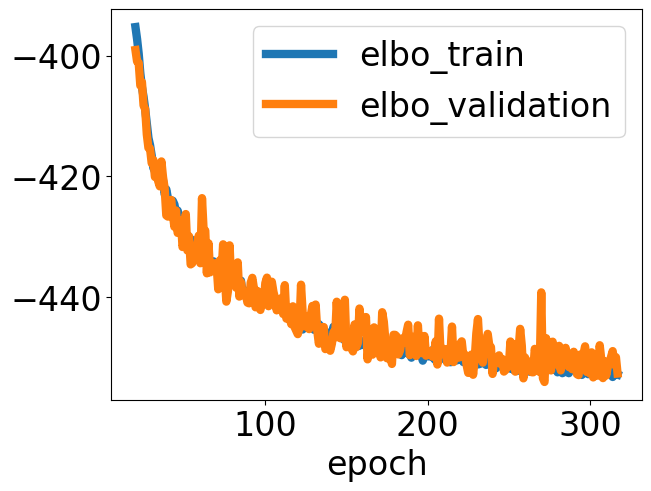

In [52]:
fig, ax = plt.subplots()
vae.history["elbo_train"].iloc[20:].plot(ax=ax, label="train")
vae.history["elbo_validation"].iloc[20:].plot(ax=ax, label="validation")
plt.legend()

In [53]:
def add_velovi_outputs_to_adata(adata, vae):
    latent_time = vae.get_latent_time(n_samples=25)
    velocities = vae.get_velocity(n_samples=25, velo_statistic="mean")

    t = latent_time
    scaling = 20 / t.max(0)

    adata.layers["velocity"] = velocities / scaling
    adata.layers["latent_time_velovi"] = latent_time

    adata.var["fit_alpha"] = vae.get_rates()["alpha"] / scaling
    adata.var["fit_beta"] = vae.get_rates()["beta"] / scaling
    adata.var["fit_gamma"] = vae.get_rates()["gamma"] / scaling
    adata.var["fit_t_"] = (
        torch.nn.functional.softplus(vae.module.switch_time_unconstr)
        .detach()
        .cpu()
        .numpy()
    ) * scaling
    adata.layers["fit_t"] = latent_time.values * scaling[np.newaxis, :]
    adata.var['fit_scaling'] = 1.0

add_velovi_outputs_to_adata(vdata, vae)

In [54]:
scv.tl.velocity_graph(vdata)

computing velocity graph (using 1/88 cores)


  0%|          | 0/10000 [00:00<?, ?cells/s]

    finished (0:00:16) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:06) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


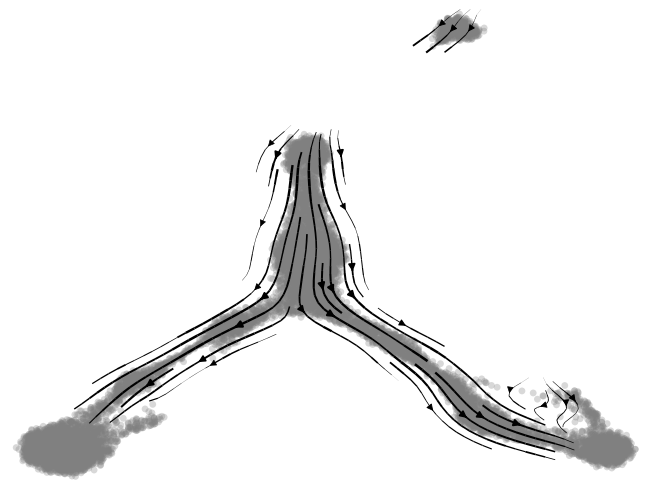

In [55]:
scv.pl.velocity_embedding_stream(vdata, basis='umap')

In [56]:
vdata.layers["latent_time_velovi"].shape

(10000, 131)

In [57]:
vdata.write("results/dyngen/bif_1_10000_velovi.h5ad")

In [72]:
vdata = sc.read("results/dyngen/bif_1_10000_velovi.h5ad")

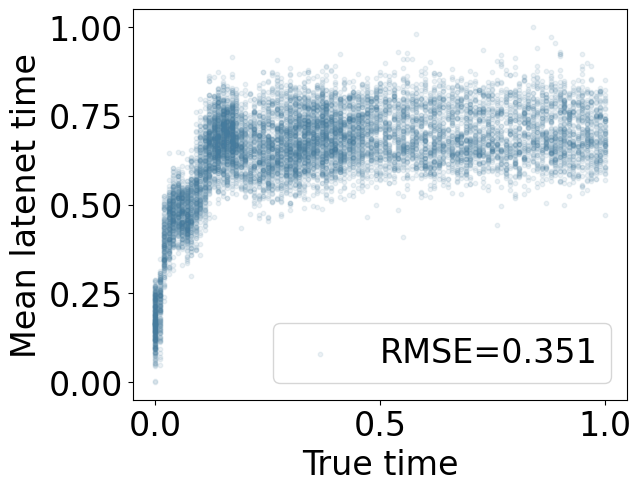

In [73]:
# Extract pseudotime
t = vdata.layers["latent_time_velovi"].mean(1)
true_t = vdata.obs["sim_time"]

# Normalize
true_t = norm(true_t)
t = norm(t)

# Remove NaN values
mask = ~np.isnan(t) & ~np.isinf(t)  # Mask to ignore NaNs in both true_t and t
filtered_t = t[mask]
filtered_true_t = true_t[mask]

# Calculate RMSE
rmse = np.sqrt(np.mean((filtered_true_t - filtered_t) ** 2))

# Plot the results
plt.scatter(filtered_true_t, filtered_t, s=10, color='#457b9d', alpha=0.1, label='RMSE=' + str(np.around(rmse, 3)))
plt.xlabel('True time')
plt.ylabel('Mean latenet time')
plt.legend()
plt.show()